In [1]:
import os
import hydra
import logging
import json
import pandas as pd
import joblib
import warnings
import rootutils
import numpy as np
from pathlib import Path
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from sklearn.metrics import f1_score

rootutils.setup_root(search_from="../", indicator=".project-root", pythonpath=True)

from src.experiment.utils import (
    assign_fold_index,
    plot_confusion_matrix,
    visualize_feature_importance,
    plot_label_distributions,
)
from src.experiment.feature.runner import run_extractors
from src.experiment.metrics import macro_f1_from_proba
from src.experiment.model.runner import train_cv_tabular_v1, predict_cv_tabular_v1
from src.experiment.optimization import find_optimal_threshold_for_label, decode_label
from src.experiment.model.custom_metrics import lgb_macro_auc, lgb_macro_f1

In [2]:
OVERRIDES: list[str] = os.getenv("OVERRIDES", "experiment=039-classifier_v1").split(",")

In [3]:
if OVERRIDES is None:
    raise ValueError("OVERRIDES is not set")

with initialize(version_base=None, config_path="../configs"):
    CFG = compose(
        config_name="config.yaml",
        return_hydra_config=True,
        overrides=OVERRIDES,
    )
    HydraConfig.instance().set_config(CFG)  # use HydraConfig for notebook to use hydra job

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

if not logger.handlers:
    handler = logging.StreamHandler()
    logger.addHandler(handler)


warnings.filterwarnings("ignore")
INPUT_DIR = Path(CFG.paths.input_dir)
OUTPUT_DIR = Path(CFG.paths.output_dir)

### Load Data


In [4]:
def assign_meta(df: pd.DataFrame, data="train"):
    df["data"] = data
    df["fold"] = -1
    return df


def align_train_test_unique(train, test, ignore_columns=["uid", "data", "fold", "created_at"], fill_value=np.nan):
    """
    This function modifies both 'train' and 'test' DataFrames. For each column,
    it replaces values that are unique to either set (not common to both) with NaN.

    :param train: DataFrame used for training.
    :param test: DataFrame used for testing.
    :return: Tuple of modified train and test DataFrames.
    """
    aligned_train = train.copy()
    aligned_test = test.copy()

    for column in train.columns:
        if column in ignore_columns:
            continue
        if column in test.columns:
            # Find values that are not common to both train and test sets
            common_values = set(train[column]).intersection(set(test[column]))

            aligned_train[column] = train[column].apply(lambda x: x if x in common_values else fill_value)
            aligned_test[column] = test[column].apply(lambda x: x if x in common_values else fill_value)

    return aligned_train, aligned_test


def replace_rare_values(df, cols, threshold, replacement_value):
    """
    This function replaces values in each column of the DataFrame that appear less frequently
    than the specified threshold with a specified replacement value.

    :param df: DataFrame to process.
    :param threshold: Frequency threshold. Values appearing less than this will be replaced.
    :param replacement_value: The value to replace rare values with.
    :return: Modified DataFrame.
    """
    for column in cols:
        value_counts = df[column].value_counts()
        values_to_replace = value_counts[value_counts < threshold].index

        df[column] = df[column].apply(lambda x: replacement_value if x in values_to_replace else x)
    return df


train_df = pd.read_csv(INPUT_DIR / "train.csv").rename(columns={"Unnamed: 0": "uid"})
test_df = pd.read_csv(INPUT_DIR / "test.csv").rename(columns={"Unnamed: 0": "uid"})
sample_submission_df = pd.read_csv(INPUT_DIR / "sample_submission.csv")

train_df = assign_meta(train_df, data="train")
test_df = assign_meta(test_df, data="test")

if CFG.align_train_test:
    train_df, test_df = align_train_test_unique(
        train=train_df,
        test=test_df,
        ignore_columns=[
            "uid",
            "data",
            "fold",
            "created_at",
            "tree_dbh",
            # "spc_common",
            # "spc_latin",
        ],
    )  #  test にないものは nan にする

for col in test_df.columns:
    if test_df[col].dtype == "float":
        continue
    logger.info(f"{col}: {train_df[col].nunique()}, {test_df[col].nunique()}")

uid: 19984, 19702
created_at: 447, 447
tree_dbh: 42, 44
curb_loc: 2, 2
steward: 3, 3
guards: 3, 3
sidewalk: 2, 2
user_type: 3, 3
problems: 73, 73
spc_common: 118, 118
spc_latin: 118, 118
nta: 184, 184
nta_name: 184, 184
borocode: 5, 5
boro_ct: 971, 971
boroname: 5, 5
zip_city: 45, 45
cb_num: 59, 59
st_senate: 26, 26
st_assem: 65, 65
cncldist: 51, 51
data: 1, 1
fold: 1, 1


### CV Split


In [5]:
kfold = hydra.utils.instantiate(CFG.cv)
train_df = assign_fold_index(train_df=train_df, kfold=kfold, y_col="health")

raw_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

if CFG.replace_rare_values_threshold is not None:
    raw_df = replace_rare_values(
        df=raw_df,
        cols=[
            "spc_common",
            "spc_latin",
            "boro_ct",
            "cb_num",
            "st_assem",
            "nta",
            "nta_name",
            "zip_city",
            "borocode",
            "boroname",
            "st_senate",
            "cncldist",
        ],
        threshold=CFG.replace_rare_values_threshold,
        replacement_value=np.nan,
    )

    for col in raw_df.columns:
        logger.info(f"{col}: {raw_df[col].nunique()}")

uid: 39686
created_at: 447
tree_dbh: 44
curb_loc: 2
health: 3
steward: 3
guards: 3
sidewalk: 2
user_type: 3
problems: 73
spc_common: 118
spc_latin: 118
nta: 184
nta_name: 184
borocode: 5
boro_ct: 971
boroname: 5
zip_city: 45
cb_num: 59
st_senate: 26
st_assem: 65
cncldist: 51
data: 2
fold: 11


### Feature Engineering


In [6]:
feature_extractors = hydra.utils.instantiate(CFG.feature_extractors)

for extractor in CFG.agg_feature_extractors:
    if CFG.group_keys_for_agg is not None:
        for group_keys in CFG.group_keys_for_agg:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

for extractor in CFG.te_feature_extractors:
    if CFG.group_keys_for_te is not None:
        for group_keys in CFG.group_keys_for_te:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

raw_feature_df = run_extractors(
    input_df=raw_df,
    extractors=feature_extractors,
    dirpath=Path(CFG.paths.feature_store_dir),
    fit=True,
    cache=CFG.cache_feature_extractors,
)
assert len(raw_df) == len(raw_feature_df)

raw_feature_df = pd.concat([raw_df, raw_feature_df], axis=1)
train_feature_df = raw_feature_df.query("data == 'train'").reset_index(drop=True).astype({"health": int})
test_feature_df = raw_feature_df.query("data == 'test'").reset_index(drop=True)

feature_columns = [col for col in train_feature_df.columns if col.startswith("f_")]
logger.info(f"num features: {len(feature_columns)}")

<CreatedAtFeatureExtractorV2_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<CurbLocationFeatureExtractorV1_ffb6a02e825b9d360512f969787b1224531b252c126bdfe37bcd16e4bc25f9e8>
<StreetWidthFeatureExtractorV1_e1934d345bbdbad6b6f154ab09d29008992672b28417152d8b0cc4d67cf97d52>
<GuardsFeatureExtractorV1_32effaf7c5b3c0140641140dbe7f670e6864cab220e3ce069c29ba661bbb756d>
<SidewalkFeatureExtractorV1_11ff165eda5af11f1928f4588c36bd9dd7a3197cf1f18f4f1d741ebc6292d04e>
<UserTypeFeatureExtractorV1_807ed6f844d318d70e501ed5fcef4e2324682fd3d8bd67d9ce65f98c8fd9468f>
<ProblemsFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<RawTransformer_c4f01b5edb85ce7283293fd3521ec16ee558910166a42954cf7e8e9944cfed21>
<CreatedAtFeatureExtractorV2_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<TreeDbhFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<SpcCommonFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4

### Train


In [7]:
def assign_seed_average_pred(result_df: pd.DataFrame) -> pd.DataFrame:
    cols = [col for col in result_df.columns if col.startswith("pred_")]
    pred = 0
    for col in cols:
        pred += np.array(result_df[col].tolist())
    result_df["pred"] = list(pred / len(cols))
    return result_df.reset_index()


valid_result_df = pd.DataFrame()
all_trained_estimators = []
scores = {}
for seed in CFG.seed_average_seeds:
    logger.info(f"\n\nstart training seed={seed} 🚀")
    CFG.model.estimator.random_state = seed

    if CFG.use_cat_features:
        cat_features = [x for x in feature_columns if x.startswith("f_oe_")]
        estimator = hydra.utils.instantiate(CFG.model.estimator, cat_features=cat_features)
    else:
        estimator = hydra.utils.instantiate(CFG.model.estimator)

    fit_params = dict(hydra.utils.instantiate(CFG.model.fit_params))
    if estimator.__class__.__name__.startswith("LGBM"):
        fit_params["eval_metric"] = [
            # lgb_macro_auc,
            lgb_macro_f1,
        ]

    model_output_dir = OUTPUT_DIR / "models" / f"seed{seed}"
    trained_estimators = train_cv_tabular_v1(
        df=train_feature_df,
        estimator=estimator,
        feature_columns=feature_columns,
        target_columns=["health"],
        fit_params=fit_params,
        output_dir=model_output_dir,
        overwrite=CFG.overwrite_training,
    )

    i_valid_result_df = predict_cv_tabular_v1(
        df=train_feature_df,
        estimators=trained_estimators,
        feature_columns=feature_columns,
        predict_proba=CFG.model.predict_proba,
    )
    val_score = macro_f1_from_proba(
        y_true=i_valid_result_df["health"],
        y_pred=i_valid_result_df["pred"].tolist(),
    )
    logger.info(f"macro f1 score [seed={seed}]: {val_score}")
    scores[f"seed{seed}"] = val_score

    valid_result_df = pd.concat(
        [
            valid_result_df,
            i_valid_result_df[["uid", "pred", "health"]]
            .set_index(["uid", "health"])
            .rename(columns={"pred": f"pred_{seed}"}),
        ],
        axis=1,
    )
    all_trained_estimators.extend(trained_estimators)


valid_result_df = assign_seed_average_pred(valid_result_df)
val_proba = np.array(valid_result_df["pred"].tolist())
val_score = macro_f1_from_proba(y_true=valid_result_df["health"], y_pred=val_proba)
scores["all_nomal"] = val_score

opt_results, val_pred_label = find_optimal_threshold_for_label(
    proba_matrix=val_proba,
    true_labels=valid_result_df["health"],
    label_indices=[2, 0, 1],
)
best_f1_score = f1_score(
    y_true=valid_result_df["health"],
    y_pred=val_pred_label,
    average="macro",
)
scores["all_opt"] = best_f1_score

logger.info(f"macro f1 score: {val_score}")
logger.info(f"optimized thresholds: {opt_results}")
logger.info(f"best f1 score: {best_f1_score}")

joblib.dump(valid_result_df[["uid", "health", "pred"]], OUTPUT_DIR / "valid_result_df.pkl")
json.dump(scores, open(OUTPUT_DIR / "scores.json", "w"))



start training seed=0 🚀
start training fold=0 🚀 
estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14175, number of negative: 3810
[LightGBM] [Info] Number of positive: 629, number of negative: 17356
[LightGBM] [Info] Total Bins 141205
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.990301	valid_0's macro_f1: 0.348407
[200]	valid_0's multi_logloss: 0.929151	valid_0's macro_f1: 0.357571
[300]	valid_0's multi_logloss: 0.887413	valid_0's macro_f1

start training fold=1 🚀 
estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141293
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.992129	valid_0's macro_f1: 0.348811
[200]	valid_0's multi_logloss: 0.931488	valid_0's macro_f1: 0.357901


start training fold=2 🚀 


Early stopping, best iteration is:
[186]	valid_0's multi_logloss: 0.938319	valid_0's macro_f1: 0.365421


estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141210
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.991015	valid_0's macro_f1: 0.368677


start training fold=3 🚀 


[200]	valid_0's multi_logloss: 0.930176	valid_0's macro_f1: 0.358882
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.991015	valid_0's macro_f1: 0.368677


estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141173
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.992343	valid_0's macro_f1: 0.34018
[200]	valid_0's multi_logloss: 0.930191	valid_0's macro_f1: 0.359877
[300]	valid_0's multi_logloss: 0.888918	valid_0's macro_f1:

start training fold=4 🚀 


Early stopping, best iteration is:
[264]	valid_0's multi_logloss: 0.901838	valid_0's macro_f1: 0.368715


estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141259
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.984295	valid_0's macro_f1: 0.386507
[200]	valid_0's multi_logloss: 0.918317	valid_0's macro_f1: 0.400823
[300]	valid_0's multi_logloss: 0.876659	valid_0's macro_f1

start training fold=5 🚀 


Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.906298	valid_0's macro_f1: 0.40452


estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141254
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.993449	valid_0's macro_f1: 0.368055


start training fold=6 🚀 


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 1.00718	valid_0's macro_f1: 0.372507


estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141248
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.983503	valid_0's macro_f1: 0.361692
[200]	valid_0's multi_logloss: 0.919045	valid_0's macro_f1: 0.377602
[300]	valid_0's multi_logloss: 0.879366	valid_0's macro_f1

start training fold=7 🚀 
estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141350
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.987783	valid_0's macro_f1: 0.36535
[200]	valid_0's multi_logloss: 0.922642	valid_0's macro_f1: 0.381737
[300]	valid_0's multi_logloss: 0.881111	valid_0's macro_f1:

start training fold=8 🚀 


Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.911755	valid_0's macro_f1: 0.388739


estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141133
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.988766	valid_0's macro_f1: 0.347749
[200]	valid_0's multi_logloss: 0.926329	valid_0's macro_f1: 0.354004


start training fold=9 🚀 


Early stopping, best iteration is:
[117]	valid_0's multi_logloss: 0.975731	valid_0's macro_f1: 0.360024


estimator : LGBMModel_bdda08c6adfdfa7d092e712b689dcc8c6c02d3c1a178ece35248d5545afbcd6c


[LightGBM] [Info] Number of positive: 3181, number of negative: 14805
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 629, number of negative: 17357
[LightGBM] [Info] Total Bins 141284
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.992538	valid_0's macro_f1: 0.354346
[200]	valid_0's multi_logloss: 0.929474	valid_0's macro_f1: 0.356264


fold0 predict : test=False


Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.957746	valid_0's macro_f1: 0.363811


fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False
fold5 predict : test=False
fold6 predict : test=False
fold7 predict : test=False
fold8 predict : test=False
fold9 predict : test=False
macro f1 score [seed=0]: 0.37553431125202574


start training seed=1 🚀
start training fold=0 🚀 
estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14175, number of negative: 3810
[LightGBM] [Info] Number of positive: 629, number of negative: 17356
[LightGBM] [Info] Total Bins 141205
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.988863	valid_0's macro_f1: 0.339817
[200]	valid_0's multi_logloss: 0.928746	valid_0's macro_f1: 0.355614


start training fold=1 🚀 


Early stopping, best iteration is:
[186]	valid_0's multi_logloss: 0.935922	valid_0's macro_f1: 0.361824


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141293
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.99205	valid_0's macro_f1: 0.34243
[200]	valid_0's multi_logloss: 0.93318	valid_0's macro_f1: 0.346815


start training fold=2 🚀 


Early stopping, best iteration is:
[190]	valid_0's multi_logloss: 0.938105	valid_0's macro_f1: 0.353064


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141210
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.992279	valid_0's macro_f1: 0.35666
[200]	valid_0's multi_logloss: 0.930727	valid_0's macro_f1: 0.350179


start training fold=3 🚀 


Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.957745	valid_0's macro_f1: 0.365129


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141173
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.990577	valid_0's macro_f1: 0.344421


start training fold=4 🚀 


Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 1.075	valid_0's macro_f1: 0.347522


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141259
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.983347	valid_0's macro_f1: 0.379603
[200]	valid_0's multi_logloss: 0.918605	valid_0's macro_f1: 0.387405


start training fold=5 🚀 


Early stopping, best iteration is:
[182]	valid_0's multi_logloss: 0.928084	valid_0's macro_f1: 0.389983


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141254
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.992565	valid_0's macro_f1: 0.36301


start training fold=6 🚀 


Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 1.01536	valid_0's macro_f1: 0.369383


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141248
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.985392	valid_0's macro_f1: 0.366091
[200]	valid_0's multi_logloss: 0.919662	valid_0's macro_f1: 0.38461
[300]	valid_0's multi_logloss: 0.87727	valid_0's macro_f1: 

start training fold=7 🚀 


Early stopping, best iteration is:
[235]	valid_0's multi_logloss: 0.901936	valid_0's macro_f1: 0.38541


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141350
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.988453	valid_0's macro_f1: 0.37119
[200]	valid_0's multi_logloss: 0.923797	valid_0's macro_f1: 0.379792
[300]	valid_0's multi_logloss: 0.882295	valid_0's macro_f1:

start training fold=8 🚀 


Early stopping, best iteration is:
[249]	valid_0's multi_logloss: 0.901269	valid_0's macro_f1: 0.389503


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141133
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.988475	valid_0's macro_f1: 0.357524
[200]	valid_0's multi_logloss: 0.92584	valid_0's macro_f1: 0.355855


start training fold=9 🚀 


Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 0.971853	valid_0's macro_f1: 0.364617


estimator : LGBMModel_8c50cfe5a915d163492fc463a5157eee00339c6f016800f9f6bc3dcd8e5c6749


[LightGBM] [Info] Number of positive: 3181, number of negative: 14805
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 629, number of negative: 17357
[LightGBM] [Info] Total Bins 141284
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.99256	valid_0's macro_f1: 0.347074
[200]	valid_0's multi_logloss: 0.929656	valid_0's macro_f1: 0.365308


fold0 predict : test=False


Early stopping, best iteration is:
[181]	valid_0's multi_logloss: 0.940561	valid_0's macro_f1: 0.3716


fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False
fold5 predict : test=False
fold6 predict : test=False
fold7 predict : test=False
fold8 predict : test=False
fold9 predict : test=False
macro f1 score [seed=1]: 0.3701953924696975


start training seed=2 🚀
start training fold=0 🚀 
estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14175, number of negative: 3810
[LightGBM] [Info] Number of positive: 629, number of negative: 17356
[LightGBM] [Info] Total Bins 141205
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.992129	valid_0's macro_f1: 0.348447
[200]	valid_0's multi_logloss: 0.929546	valid_0's macro_f1: 0.365737
[300]	valid_0's multi_logloss: 0.888734	valid_0's macro_f1

start training fold=1 🚀 
estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141293
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.991083	valid_0's macro_f1: 0.34793


start training fold=2 🚀 


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 1.00747	valid_0's macro_f1: 0.356752


estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141210
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.99126	valid_0's macro_f1: 0.350093
[200]	valid_0's multi_logloss: 0.929074	valid_0's macro_f1: 0.358342
[300]	valid_0's multi_logloss: 0.890174	valid_0's macro_f1:

start training fold=3 🚀 


Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.917802	valid_0's macro_f1: 0.366996


estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3181, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3809
[LightGBM] [Info] Number of positive: 628, number of negative: 17357
[LightGBM] [Info] Total Bins 141173
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.989462	valid_0's macro_f1: 0.34143
[200]	valid_0's multi_logloss: 0.92758	valid_0's macro_f1: 0.356225
[300]	valid_0's multi_logloss: 0.886876	valid_0's macro_f1: 

start training fold=4 🚀 
estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141259
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.983247	valid_0's macro_f1: 0.3823
[200]	valid_0's multi_logloss: 0.916085	valid_0's macro_f1: 0.393265
[300]	valid_0's multi_logloss: 0.874166	valid_0's macro_f1: 

start training fold=5 🚀 


Early stopping, best iteration is:
[238]	valid_0's multi_logloss: 0.897976	valid_0's macro_f1: 0.399874


estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141254
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.991844	valid_0's macro_f1: 0.368785


start training fold=6 🚀 


Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 1.02316	valid_0's macro_f1: 0.375854


estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141248
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.98398	valid_0's macro_f1: 0.365457
[200]	valid_0's multi_logloss: 0.919526	valid_0's macro_f1: 0.371806
[300]	valid_0's multi_logloss: 0.878277	valid_0's macro_f1:

start training fold=7 🚀 
estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141350
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.986605	valid_0's macro_f1: 0.364732
[200]	valid_0's multi_logloss: 0.922076	valid_0's macro_f1: 0.374903
[300]	valid_0's multi_logloss: 0.880133	valid_0's macro_f1

start training fold=8 🚀 


Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.892981	valid_0's macro_f1: 0.39177


estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3182, number of negative: 14804
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 628, number of negative: 17358
[LightGBM] [Info] Total Bins 141133
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.989859	valid_0's macro_f1: 0.354205
[200]	valid_0's multi_logloss: 0.926521	valid_0's macro_f1: 0.366096
Early stopping, best iteration is:
[172]	valid_0's multi_l

start training fold=9 🚀 
estimator : LGBMModel_83d29522d22781411bf006b82f4b023deb1c6aebfcb766f8fc4847cb429f0399


[LightGBM] [Info] Number of positive: 3181, number of negative: 14805
[LightGBM] [Info] Number of positive: 14176, number of negative: 3810
[LightGBM] [Info] Number of positive: 629, number of negative: 17357
[LightGBM] [Info] Total Bins 141284
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1860
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.991494	valid_0's macro_f1: 0.35309
[200]	valid_0's multi_logloss: 0.93019	valid_0's macro_f1: 0.356194
Early stopping, best iteration is:
[169]	valid_0's multi_log

fold0 predict : test=False
fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False
fold5 predict : test=False
fold6 predict : test=False
fold7 predict : test=False
fold8 predict : test=False
fold9 predict : test=False
macro f1 score [seed=2]: 0.37577870602591074
macro f1 score: 0.3714977972809101
optimized thresholds: {2: {'threshold': 0.4545454545454546, 'f1': 0.371734902746285}, 0: {'threshold': 0.5454545454545455, 'f1': 0.371734902746285}, 1: {'threshold': 0.393939393939394, 'f1': 0.37435796820170303}}
best f1 score: 0.37435796820170303


### Visualization


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaV

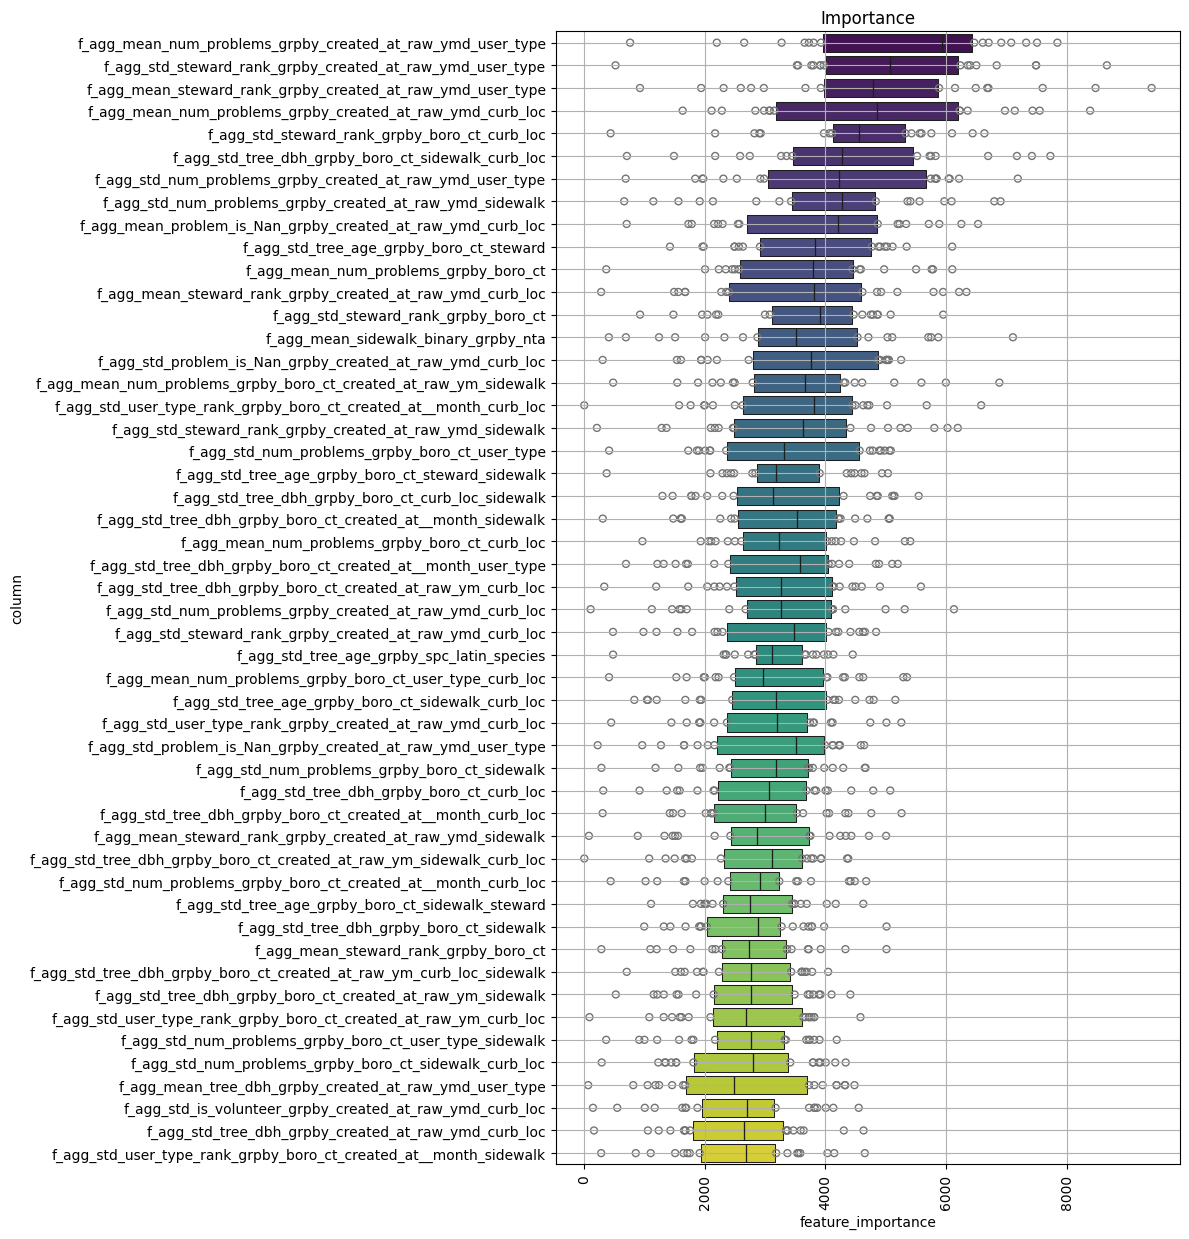

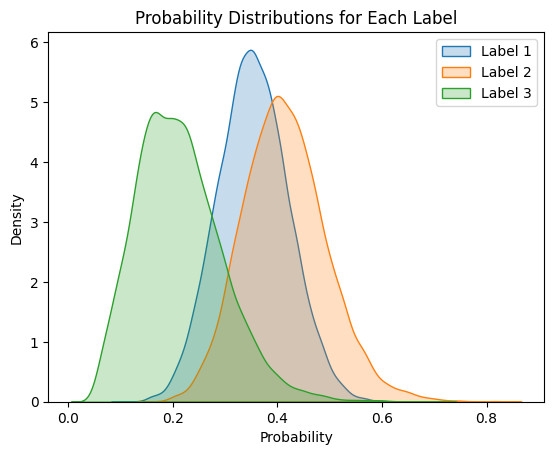

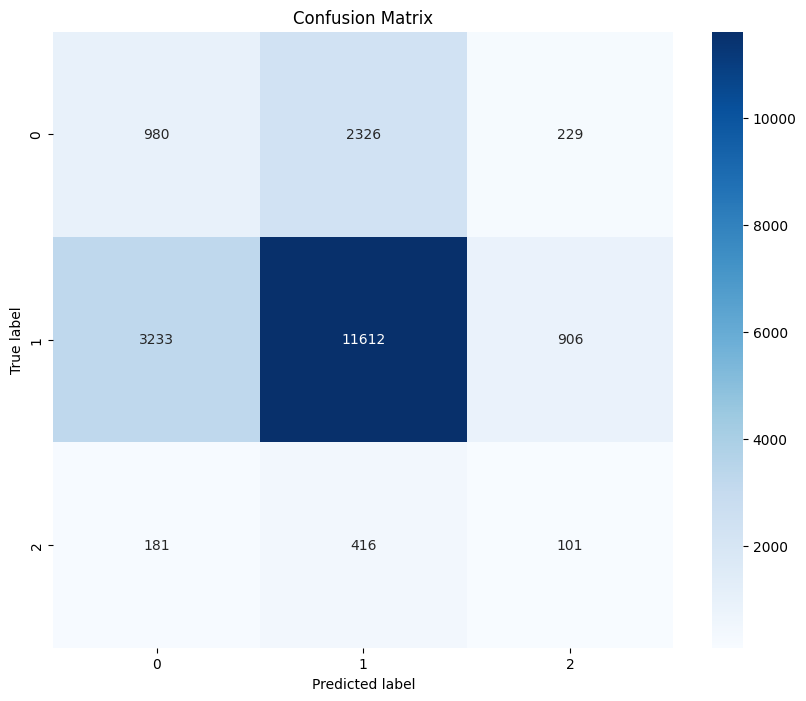

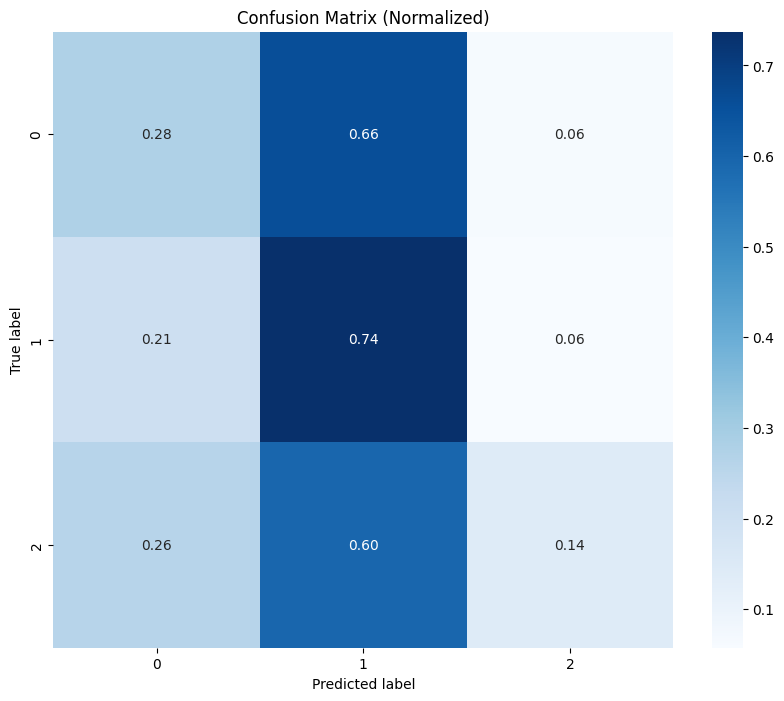

In [8]:
fig, importance_df = visualize_feature_importance(
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    top_n=50,
)
fig.savefig(OUTPUT_DIR / "feature_importance.png", dpi=300)
importance_df.to_csv(OUTPUT_DIR / "feature_importance.csv", index=False)


fig = plot_label_distributions(proba_matrix=np.array(valid_result_df["pred"].tolist()))
fig.show()
fig.savefig(OUTPUT_DIR / "label_distributions.png", dpi=300)


fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label)
fig.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=300)

fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label, normalize=True)
fig.savefig(OUTPUT_DIR / "confusion_matrix_normalized.png", dpi=300)

### Make submission


In [9]:
test_result_df = predict_cv_tabular_v1(
    df=test_feature_df,
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    test=True,
    predict_proba=CFG.model.predict_proba,
)

test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["pred"] = np.argmax(test_pred_df.groupby("uid").mean(), axis=1)
submission_df = test_df[["uid", "pred"]]
submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}.csv"
submission_df.to_csv(submission_filepath, index=False, header=False)

fold0 predict : test=True
fold1 predict : test=True
fold2 predict : test=True
fold3 predict : test=True
fold4 predict : test=True
fold5 predict : test=True
fold6 predict : test=True
fold7 predict : test=True
fold8 predict : test=True
fold9 predict : test=True
fold10 predict : test=True
fold11 predict : test=True
fold12 predict : test=True
fold13 predict : test=True
fold14 predict : test=True
fold15 predict : test=True
fold16 predict : test=True
fold17 predict : test=True
fold18 predict : test=True
fold19 predict : test=True
fold20 predict : test=True
fold21 predict : test=True
fold22 predict : test=True
fold23 predict : test=True
fold24 predict : test=True
fold25 predict : test=True
fold26 predict : test=True
fold27 predict : test=True
fold28 predict : test=True
fold29 predict : test=True


In [10]:
test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["opt_pred"] = decode_label(proba_matrix=test_pred_df.groupby("uid").mean().to_numpy(), thresholds=opt_results)

submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}_opt_{best_f1_score:.3f}.csv"
test_df[["uid", "opt_pred"]].to_csv(submission_filepath, index=False, header=False)

joblib.dump(test_pred_df, OUTPUT_DIR / "test_result_df.pkl")

['/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/resources/outputs/experiment=039-classifier_v1/test_result_df.pkl']

In [11]:
print(test_df["opt_pred"].value_counts() / len(test_df))

opt_pred
1    0.743224
0    0.215054
2    0.041722
Name: count, dtype: float64


In [12]:
test_df["pred"].value_counts() / len(test_df)

pred
1    0.685260
0    0.272663
2    0.042077
Name: count, dtype: float64

In [13]:
train_df["health"].value_counts() / len(train_df)

health
1    0.788181
0    0.176892
2    0.034928
Name: count, dtype: float64

In [14]:
def plot_dist_by_color(df, value_col, color_col):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    for color in df[color_col].unique():
        sns.distplot(df[value_col][df[color_col] == color], hist=False, label=color)

    plt.title("Distribution of Values Color-Coded by Color")
    plt.legend()
    plt.show()